# Implementation and notes on Noisy Dueling Double DQN with N-step PER.
This will be some notes on how to build up the Rainbow DQN, but leaving out the categorization.


## 0. imports

In [1]:
# STD
import os
import time
import math
from collections import namedtuple, deque
from pathlib import Path

# Visualize and data
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Game env
from unityagents import UnityEnvironment

# Personal lib:
import log

## 1. initialise game

In [2]:
# take test seed:
use_test_seed = False
test_seed = np.random.randint(low=1, high=1000)

#Seed values from now on.
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# Game values
game = "D:\dev\learning\DRL-project\DRL-course\projects\p1_navigation\Banana.exe"
env = UnityEnvironment(file_name=game, seed=test_seed if use_test_seed else seed, no_graphics=False)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# game info:
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

general_info = log.create_general_info("*general info:*", game, seed, state_size, action_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2. Hyperparameters
Here we go through all the hyperparameters
### 2.1 model parameters
Using a noisy DQN we need to have a initialised noise value:

In [3]:
std_init = 0.2                      # The amount of noise applied
model_info = log.create_model_info("*model info:*", std_init)

### 2.2 Prioritised Experience Replay buffer parameter

In [4]:
BUFFER_SIZE = (2 ** 20)             # The space we use to store Experiences 
BATCH_SIZE = 512                    # Amount of replays we train on each update.
RB_method = "nstep_per"             # Choice of replay buffer: nstep_per, (per, replay_buffer)=not_implemented
PER_e = 0.01                        # Epsilon
PER_a = 0.6                         # Alpha
PER_b = 0.4                         # Beta init
PER_bi = 0.00001                    # Beta increase is the increase in taking the most prioritiesed replays
PER_aeu = 3                         # Absolute error upper is the max priority a replay can have
PER_learn_start = 0                 # Used to populated the sumtree with replays
n_step = 8                          # Used in the n-step implementation for choosing how many sequent replays we use.
per_info = log.create_per_info("*per_info:*", BUFFER_SIZE, BATCH_SIZE, \
                               RB_method, PER_e, PER_a, PER_b, PER_bi, PER_aeu, PER_learn_start, n_step)

### 2.3 Agent parameters

In [5]:
GAMMA = 0.99                       # Future discount value
TAU = 1e-3                         # Amount we update the target model each update session (use_soft_update=True)
LR = 0.00005                       # The learning rate of the model
opt_eps = 1.5e-4                   # Adam epsilon (more info)
UPDATE_MODEL_EVERY = 10            # The amount of steps between model updates 
UPDATE_TARGET_EVERY = 8000         # The amount of steps between target updates (use_soft_update=Flase)
use_soft_update = True             # Wether we are updating the model using soft updates or copying model weights over.
priority_method = "reward"         # Initialised priorities (reward, none=max_val, error=compute_error)

agent_info = log.create_agent_info("*agent info:*", GAMMA, TAU, LR, opt_eps,
                               UPDATE_MODEL_EVERY, UPDATE_TARGET_EVERY, use_soft_update, priority_method)

### 2.4 Training parameters

In [6]:
episodes = 500                    # Number of training episodes
evaluation_interval = 200         # Indicating how often we evaluate the current agent.
max_t = 1000                      # The max number of steps before going into new episode (not used)
train_info = log.create_train_info("*train_info:*", episodes, evaluation_interval, max_t)

## 3. Model and layers: Noisy Dueling DQN
Noisy DQN is that we apply noise to the last layers to emulated exploration.
Dueling DQN is that we split the last layer into two and compute an advangtage vector (How good are each action in this state) and a value (how good is the state). This helps us when training the network to have a... 
### 3.1 Noisy layer
parameter explained:
weight_mu:

weight_sigma:

register_buffer("weight_epsilon"):

bias_mu:

bias_sigma:

register_buffer("bias_epsilon"):


In [7]:
class FactorizedNoisyLinear(nn.Module):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def __init__(self, 
                 in_features,       # Number of input features
                 out_features,      # Number of output features
                 std_init,          # Amount of noise in layer
                 seed=None,         # The env seed (if needed)     
                 name="noisyLinear" # Name for debugging
                ):
        super(FactorizedNoisyLinear, self).__init__()
        if seed is not None:
            self.seed = seed
            torch.manual_seed(self.seed)

        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.Tensor(out_features, in_features))
        
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.std_init = std_init
        self.name = name

        self.reset_parameters()
        self.reset_noise()

    def forward(self, x):
        """
        Applying noise to the weights and bias to simulate exploring
        :param x: The input state
        :return: Linear translation with noisy weights and bias.
        """
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu

        y = F.linear(x, weight, bias)

        return y

    def reset_parameters(self):
        std = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-std, std)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))

        self.bias_mu.data.uniform_(-std, std)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul_(x.abs().sqrt_())


### 3.2 The Noisy Dueling DQN Model

In [8]:
class NoisyDDQN(nn.Module):
    def __init__(self, state_size, action_size, std_init, seed=None):
        super(NoisyDDQN, self).__init__()
        if seed is not None:
            torch.manual_seed(seed)
        self.action_size = action_size
        self.state_size = state_size

        self.feature_layer = nn.Sequential(
            nn.Linear(self.state_size, 512),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            FactorizedNoisyLinear(512, 512, std_init=std_init, seed=seed, name="value_stream1"),
            nn.ReLU(),
            FactorizedNoisyLinear(512, 1, std_init=std_init, seed=seed, name="value_stream2")
        )

        self.advantage_stream = nn.Sequential(
            FactorizedNoisyLinear(512, 512, std_init=std_init, seed=seed, name="advantage_stream1"),
            nn.ReLU(),
            FactorizedNoisyLinear(512, self.action_size, std_init=std_init, seed=seed, name="advantage_stream2")
        )

        self.feature_layer.apply(self.init_weights)
        self.value_stream.apply(self.init_weights)
        self.advantage_stream.apply(self.init_weights)

    def forward(self, state):
        x = self.feature_layer(state)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value.expand_as(advantage) + (
                advantage - advantage.mean(dim=state.dim() - 1, keepdim=True).expand_as(advantage))
        return q_values

    def reset_noise(self):
        for module in self.modules():
            if isinstance(module, FactorizedNoisyLinear):
                module.reset_noise()

    def set_training(self, training):
        for module in self.modules():
            if isinstance(module, FactorizedNoisyLinear):
                module.is_training = training

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


## 4 N-step Prioritiesed Experience Replay buffer
In **the Prioritiesed Experience Replay** (PER) buffer, we do not chose the experience replays at random but weights the less seen or valueable experiences with a higher priority to better cover the information given from this experience.

**The N-step** implementation aims to improve the temporal awareness of the agent, by combining the information of current state and action with the next N-steps into the future. This way we try to learn if a state is contributing to future rewards.

We store the priorities of the experiences in a sumtree for faster search and updates.
### 4.1 Sumtree

In [9]:
class SumTree:
    def __init__(self, capacity, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        self.capacity = int(capacity)
        assert self.is_power_of_2(self.capacity), "Capacity must be power of 2." + str(capacity)
        # pointer to current index in data map.
        self.data_pointer = 0
        self.data = np.zeros(capacity, dtype=object)
        self.data_length = 0
        # Priority tree.
        self.tree = np.zeros(2 * capacity - 1)

    def __len__(self):
        return self.data_length

    def add(self, data, priority):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1
        # Update data frame
        self.data[self.data_pointer] = data
        # Update the leaf
        self.update(tree_index, priority)
        # Add 1 to data_pointer
        self.data_pointer = (self.data_pointer + 1) % self.capacity
        if self.data_length < self.capacity:
            self.data_length += 1

    def update(self, tree_index, priority):
        # change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get_leaf(self, value):
        parent_index = 0  # root
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else:  # downward search, always search for a higher priority node
                if value <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    value -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, data_index, self.tree[leaf_index], self.data[data_index]

    # Returns data given a data index
    def get_data(self, data_index):
        return self.data[data_index % self.capacity]

    @staticmethod
    def is_power_of_2(n):
        return ((n & (n - 1)) == 0) and n != 0

    @property
    def total_priority(self):
        return self.tree[0]  # the root

    @property
    def max_priority(self):
        return np.max(self.tree[-self.data_length:])

    @property
    def min_priority(self):
        return np.min(self.tree[-self.data_length:])


### 4.2 N-step PER buffer

In [10]:
class PerNStep:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def __init__(self, capacity, batch_size, state_size, seed=None, epsilon=.001, alpha=.6, beta=.4, beta_increase=1e-3,
                 absolute_error_upper=3, n_step=3, gamma=.99):
        """
        :param capacity: Max amount of experience saved in the structure
        :param epsilon: small value to insure all probabilities is not 0
        :param alpha: introduces some randomness and to insure we don't train the same experience and overfit
                      alpha=1 means greedy selecting the experience with highest priority
                      alpha=0 means pure uniform randomness
        :param beta: controls how much IS w affect learning
                     beta>=0, starts close to 0 and get closer and closer to 1
                     because these weights are more important in the end of learning when our q-values
                     begins to convert
        :param beta_increase: is the increase in beta for each sampling. 0.001 = 1e-3
        :param absolute_error_upper: Setting a cap on how big an error (priority) can be.
        :param n_step: store the most recent n-step transitions or experiences instead of the default 1.
        :param gamma: This is the discount value
        """
        ## Just like PER
        # seeding
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        # init
        self.capacity = capacity
        self.batch_size = batch_size
        self.memory_tree = SumTree(self.capacity, seed)
        self.experience = namedtuple("Experience",
                                     field_names=["timestep", "state", "action", "reward", "next_state", "done"])

        self.epsilon = epsilon
        self.alpha = alpha
        self.beta = beta
        self.beta_increase = beta_increase
        self.absolute_error_upper = absolute_error_upper
        self.seed = seed

        ## N-Step
        self.t = 0  # Internal time step counter
        self.n_step = n_step
        self.n_step_buff = deque(maxlen=n_step)
        self.gamma = gamma
        self.blank_experience = self.experience(timestep=0,
                                                state=torch.zeros(state_size, dtype=torch.float64),
                                                action=None,
                                                reward=0,
                                                next_state=torch.zeros(state_size, dtype=torch.float64),
                                                done=False)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory_tree)

    def is_full(self):
        return len(self.memory_tree) >= self.memory_tree.capacity

    def sample(self):
        """
                - First, to sample a minibatch of size k the range [0, priority_total] is divided into k ranges.
                - Then a value is uniformly sampled from each range.
                - We search in the sumtree, the experience where priority score correspond to sample values are retrieved from.
                - Then, we calculate IS weights for each minibatch element.

                The difference here from the last structure is that we need to move to device
                in the method calling this function.

                so an example:
                idxs, experiences, is_weights = self.memory.sample(BATCH_SIZE)

                states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(device)
                actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).float().to(device)
                rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(device)
                next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(device)
                dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

                is_weights =  torch.from_numpy(is_weights).float().to(device)
                """

        minibatch = []

        idxs = np.empty((self.batch_size,), dtype=np.int32)
        is_weights = np.empty((self.batch_size,), dtype=np.float32)

        # Calculate the priority segment
        # Divide the Range[0, ptotal] into n ranges
        priority_segment = self.memory_tree.total_priority / self.batch_size  # priority segment

        # Increase the beta each time we sample a new minibatch
        self.beta = np.amin([1., self.beta + self.beta_increase])  # max = 1

        for i in range(self.batch_size):
            """
            A value is uniformly sampled from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)

            # This while is to counter that we find a leaf that is not populated yet.
            # It happens when the buffer size is very large.
            leaf_index, data_index, priority, data = 0, 0, 0, 0
            while data == 0:
                value = np.random.uniform(a, b)

                """
                Experience that corresponds to each value is retrieved
                """
                leaf_index, data_index, priority, data = self.memory_tree.get_leaf(value)

            # P(i) = p_i**a / sum_k p_k**a
            sampling_probabilities = priority / self.memory_tree.total_priority

            # (1/N * 1/P(i))**b and to normalize it we divide with max_weight
            # So is_weights[i] = (1/N * 1/P(i))**b
            is_weights[i] = np.power(self.batch_size * sampling_probabilities, -self.beta)

            idxs[i] = leaf_index
            minibatch.append(data)
        is_weights /= is_weights.max()
        return idxs, minibatch, is_weights

    def add(self, state, action, reward, next_state, done, error=None):
        exp = self.experience(self.t, torch.from_numpy(state), action, reward, torch.from_numpy(next_state), done)
        self.n_step_buff.append(exp)
        self.t = (0 if done else self.t + 1)
        if len(self.n_step_buff) < self.n_step:
            return None
        exp, priority = self._get_n_step_info(self.n_step_buff, self.gamma)
        priority = min((abs(priority) + self.epsilon) ** self.alpha, self.absolute_error_upper)
        self.memory_tree.add(exp, priority)

    def update_memory_tree(self, idxs, errors):
        errors = errors + self.epsilon
        clipped_errors = np.minimum(errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.alpha)

        for idx, p in zip(idxs, ps):
            self.memory_tree.update(idx, p)

    def _get_n_step_info(self, n_step_buff, gamma):
        timestep, org_state, org_action, _, _, _ = n_step_buff[0]
        relevant_transitions = []
        for transition in list(n_step_buff):
            if timestep == transition.timestep:
                relevant_transitions.append(transition)
                timestep += 1
            else:
                break
        # Take last element in deque and add the reward
        rew, n_state, done = relevant_transitions[-1][-3:]
        for transition in reversed(relevant_transitions[:-1]):
            reward, n_s, d = transition.reward, transition.next_state, transition.done
            rew = reward + gamma * rew * (1 - done)
            n_state, done = (n_s, d) if d else (n_state, done)
        return self.experience(timestep, org_state, org_action, rew, n_state, done), rew

## 5. Double DQN Agent

In [11]:
class DoubleDQN:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def __init__(self,
                 state_size, action_size, models, replay_buffer, seed=None, BATCH_SIZE=64,
                 GAMMA=0.99, TAU=1e-3, LR=5e-4, UPDATE_MODEL_EVERY=4, UPDATE_TARGET_EVERY=1000,
                 use_soft_update=False, priority_method="reward", PER_learn_start=0):
        # seed for comparison
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
            torch.manual_seed(self.seed)
        # Hyper parameters:
        self.state_size = state_size                       # Not used only for debugging
        self.action_size = action_size                     # Not used only for debugging
        self.batch_size = BATCH_SIZE                       
        self.gamma = GAMMA
        self.tau = TAU
        self.lr = LR
        self.UPDATE_MODEL_EVERY = UPDATE_MODEL_EVERY
        self.UPDATE_TARGET_EVERY = UPDATE_TARGET_EVERY
        self.use_soft_update = use_soft_update
        self.priority_method = priority_method
        self.t_step = 0
        self.learn_start = PER_learn_start

        # Double DQN or QN:
        self.model = models[0].to(self.device)
        self.model_target = models[1].to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, eps=1.5e-4)

        # N-step:
        self.n_step = n_step

        # Priority Experience Replay:
        self.memory = replay_buffer
        
        # plotting:
        self.losses = []

    def step(self, state, action, reward, next_state, done):
        """Saves learning experience in memory tree and decides if it is time to update models.

        Params
        ======
            state: The state we are moving from.
            action: What action we took.
            reward: The reward from going from state to the next state
            next_state: The state we end up in.
            done: If the game terminated after this step.
        """
        # Save experience in replay memory
        if self.priority_method == "None":
            error = None
        elif self.priority_method == "error":
            error = self.compute_error(state, action, reward, next_state, done)
        else:
            error = reward
        self.memory.add(state, action, reward, next_state, done, error)

        # Filling memory
        if self.learn_start != 0:
            self.learn_start -= 1
            if self.learn_start % 1000 == 0:
                print("\tFilling memory: \t{0}".format(self.learn_start, end="\r"))
            return
        # Update t_step:
        self.t_step += 1
        if self.t_step % self.UPDATE_MODEL_EVERY == 0 and self.t_step % self.UPDATE_TARGET_EVERY == 0:
            self.t_step = 0

        # Learn every UPDATE_EVERY time steps.
        if self.t_step % self.UPDATE_MODEL_EVERY == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                loss = self.learn()
                self.losses.append(loss)
                if self.use_soft_update:
                    self.soft_update(self.model, self.model_target, self.tau)

        if not self.use_soft_update and self.t_step % self.UPDATE_TARGET_EVERY == 0:
            self.update_target_model()
            print("\tTarget model updated")

    def act(self, state):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        # TODO: Question for reviewers, should i disable noise here? hence put it on eval mode
        #       I do see a faster growth in avg score in shorter training period,
        #       but this might be from less exploring, hence might be bad in the longer run.
        #       The noise is applied to the sampled memories under model update,
        #       so this is why we might not need it here?
        # self.model.eval() # disable noise
        with torch.no_grad():
            action_values = self.model.forward(state)
        # self.model.train() # enable noise
        return np.argmax(action_values.detach().cpu().numpy())

    def learn(self):
        """Update value parameters using given batch of experience tuples.

                Params
                ======
                    experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
                    gamma (float): discount factor
                """
        # PER:
        idxs, experiences, is_weights = self.memory.sample()
        is_weights = torch.from_numpy(is_weights).float().to(self.device)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            self.device)
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            self.device)
        
        #todo:: Test if this is ok.
        # with torch.no_grad():
        
        # Getting the max action of local network (using weights w)
        max_actions = self.model.forward(next_states).detach().max(1)[1].unsqueeze(1)

        # Getting the Q-value for these actions (using weight w^-)
        Q_targets_next = self.model_target.forward(next_states).detach().gather(1, max_actions)

        # Compute Q targets for current states (TD-target)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.model(states).gather(1, actions)

        
        # Compute loss - Per: weighted loss computed and the priorities are updated
        errors = torch.abs(Q_expected - Q_targets).detach().cpu()
        self.memory.update_memory_tree(idxs, errors)
        loss = (is_weights * F.mse_loss(Q_expected, Q_targets)).mean()
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # Resetting the noise of the model
        self.model.reset_noise()
        self.model_target.reset_noise()
        return loss.item() # Return loss for logging

    def compute_error(self, state, action, reward, next_state, done):
        """ Compute the error between model and model_target given one experience
        """
        # Set to eval to avoid backpropergation:
        self.model.eval() 
        self.model_target.eval()
        with torch.no_grad():
            state = torch.from_numpy(state).to(self.device)
            next_state = torch.from_numpy(next_state).to(self.device)
            action = torch.as_tensor(action).to(self.device)
            val, max_actions_Snext_local = self.model_target(next_state).detach().max(0)

            # Getting the Q-value for these actions (using weight w^-)
            Q_targets_next = self.model_target(next_state).detach()[max_actions_Snext_local]

            # Compute Q targets for current states (TD-target)
            Q_targets = reward + (self.gamma * Q_targets_next * (1 - done))

            # Get expected Q values from local model
            Q_expected = self.model(state)[action]

            error = np.abs((Q_expected - Q_targets).detach().cpu().numpy())
        self.model.train()
        self.model_target.train()
        return error

    def update_target_model(self):
        """ Hard update model parameters.
            Copying the current weights from DDQN to the target model.
        """
        self.model_target.load_state_dict(self.model.state_dict())

    @staticmethod
    def soft_update(local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

## 6. Train and evaluate agent:
and helping functions
### 6.1 Visualizing and helping functions

In [12]:
def movingaverage(values, window, mode='same'):
    weights = np.repeat(1.0, window) / window
    sma = np.convolve(values, weights, mode)
    return sma.tolist()


def plot_score(scores, Ln_blue, Ln_olive, fig):
    # print("plot:")
    mean_scores = []
    mean_scores.append(0)
    for i in range(0, len(scores), 5):
        l = []
        for j in range(5):
            l.append(scores[i + j])
        mean_scores.append(np.mean(l))
    # print(mean_scores)
    Ln_blue.set_ydata(mean_scores)
    Ln_blue.set_xdata(range(0, len(scores)+1, 5))
    if len(scores) >= 30:
        yMA = movingaverage(scores, 30)
        Ln_olive.set_ydata(yMA)
        Ln_olive.set_xdata(range(0, len(scores)))
    display.clear_output(wait=True)
    display.display(fig)
    
    plt.pause(0.1)
    return fig


def unpack_braininfo(brain_name, all_brain_info):
    brain_info = all_brain_info[brain_name]
    next_state = brain_info.vector_observations[0]
    reward = brain_info.rewards[0]
    done = brain_info.local_done[0]
    max_reached = brain_info.max_reached[0]
    return next_state, reward, done, max_reached

### 6.2 Evaluating:

In [13]:

def evaluate(agent, brain_name, test_env, n_episodes, train_episode="Loaded model", model_save_file=None,
         current_best=10000, set_fast_mode=True):
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    time_window = deque(maxlen=10)  # last 10 iter
    agent.model.eval()
    for i_episode in range(1, n_episodes + 1):
        state = test_env.reset(train_mode=set_fast_mode)[brain_name].vector_observations[0]
        score = 0
        start = time.time()
        max_reached = False
        while not max_reached:
            action = int(agent.act(state))
            next_state, reward, done, max_reached = unpack_braininfo(brain_name, test_env.step(action))
            state = next_state
            score += reward
            if done:
                break
        time_window.append(time.time() - start)
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        print(
            '\rTest: Episode {}\tAverage Score: {:.2f}\tthis Score: {:.2f}\tAverage Time pr episode {:.2f} seconds'.format(
                i_episode,
                np.mean(
                    scores_window),
                score,
                np.mean(
                    time_window)),
            end="")
        if i_episode % 100 == 0:
            print('Test: \rEpisode {}\tAverage Score: {:.2f}\tTime left {:.2f} seconds'.format(i_episode,
                                                                                               np.mean(scores_window),
                                                                                               np.mean(time_window) * (
                                                                                                       n_episodes - i_episode)))
            if np.mean(scores_window) >= current_best:
                if model_save_file != None:
                    torch.save(agent.model.state_dict(), str(model_save_file))
                    current_best = np.mean(scores_window)
    agent.model.train()
    return '\n\ttrain_episode: {}\t Average Score over {} episodes: {}'.format(str(train_episode), str(n_episodes),
                                                                               np.mean(scores)), current_best

### 6.3 Training

In [14]:
def train(agent, brain_name, train_env, file, save_img="plot.png", save_file='checkpoint.pth',
          n_episodes=2000000, evaluation_interval=200, plot=False, plot_title="title"):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    if plot:
        buffer = 1
        min_score = 0
        max_score = min_score + buffer
        fig = plt.figure()
        # fig, axs = plt.subplots(2, 1)
        # score_ax = axs[0]
        score_ax = fig.add_subplot(111)
        score_line_blue, = score_ax.plot([0, 0])
        score_line_olive, = score_ax.plot([0, 0], color='olive')
        score_ax.set_ylim([min_score, max_score])
        score_ax.set_xlim([0, 1])

        # loss_ax = axs[1]
        # loss_line_blue, = loss_ax.plot([0, 0])
        # loss_ax.set_ylim([0, 10])
        # loss_ax.set_xlim([0, 1])

        plt.title(plot_title)
        plt.xlabel('epoch')
        plt.ylabel('score mean over 5 epoch')
        plt.ion()
        plt.show()
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    time_window = deque(maxlen=10)  # last 10 iter
    best_avg = 13.0
    eval_result = "\n## test result: \n\n"
    for i_episode in range(1, n_episodes + 1):
        state = train_env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        start = time.time()
        max_reached = False
        while not max_reached:
            action = int(agent.act(state))
            next_state, reward, done, max_reached = unpack_braininfo(brain_name, train_env.step(action))
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        time_window.append(time.time() - start)

        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}\tthis Score: {:.2f}\tAverage Time pr episode {:.2f} seconds'.format(
            i_episode,
            np.mean(
                scores_window),
            score,
            np.mean(
                time_window)),
            end="")
        if plot and i_episode % 5 == 0:
            # score
            # Update axis:
            window = scores[-5:]
            mean = np.mean(window)
            if mean > max_score - buffer:
                max_score = mean + buffer
                score_ax.set_ylim([min_score, max_score])
            if mean < min_score + buffer:
                min_score = mean - buffer
                score_ax.set_ylim([min_score, max_score])
            score_ax.set_xlim([0, len(scores)])
            # PLOT
            fig = plot_score(scores, score_line_blue, score_line_olive, fig)

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tTime left {:.2f} seconds'.format(i_episode,
                                                                                         np.mean(scores_window),
                                                                                         np.mean(time_window) * (
                                                                                                 n_episodes - i_episode)))
            with open(file, "a+") as f:
                f.write('\tEpisode {}\tAverage Score: {:.2f}\n'.format(i_episode, np.mean(scores_window)))
            if plot:
                plt.savefig(save_img)

        if np.mean(scores_window) >= best_avg:
#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tTime left {:.2f} seconds'.format(
#                 i_episode,
#                 np.mean(scores_window), np.mean(time_window) * (n_episodes - i_episode)))
            # log_result, current_best = eval(agent, brain_name, train_env, 100, i_episode, save_file, best_avg)
            # eval_result += log_result
            # best_avg = current_best
            debug =0

        if i_episode % evaluation_interval == 0:
            # Time for evaluation
            log_result, current_best = evaluate(agent, brain_name, train_env, 100, i_episode, save_file, best_avg)
            eval_result += log_result
            best_avg = current_best

    with open(file, "a+") as f:
        f.write(eval_result)
        f.write("\n\nbest score: " + str(max(scores)) + " at eps: " + str(scores.index(max(scores))))
    return scores, best_avg


## 7. Time to train:

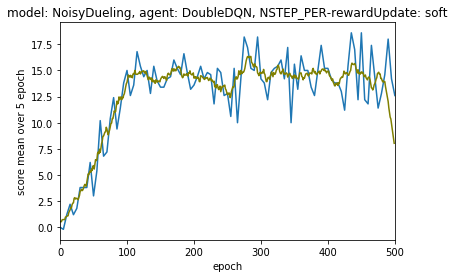

Episode 500	Average Score: 14.36	Time left 0.00 seconds


([0.0,
  2.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  1.0,
  5.0,
  1.0,
  0.0,
  4.0,
  4.0,
  1.0,
  0.0,
  2.0,
  0.0,
  0.0,
  5.0,
  1.0,
  0.0,
  0.0,
  0.0,
  7.0,
  1.0,
  1.0,
  2.0,
  0.0,
  9.0,
  4.0,
  4.0,
  6.0,
  2.0,
  8.0,
  3.0,
  0.0,
  12.0,
  3.0,
  1.0,
  3.0,
  0.0,
  2.0,
  2.0,
  8.0,
  5.0,
  14.0,
  2.0,
  4.0,
  1.0,
  3.0,
  5.0,
  7.0,
  4.0,
  3.0,
  0.0,
  13.0,
  15.0,
  10.0,
  7.0,
  11.0,
  8.0,
  2.0,
  11.0,
  4.0,
  15.0,
  2.0,
  2.0,
  17.0,
  14.0,
  0.0,
  3.0,
  20.0,
  6.0,
  3.0,
  18.0,
  5.0,
  13.0,
  18.0,
  8.0,
  17.0,
  6.0,
  13.0,
  9.0,
  4.0,
  13.0,
  8.0,
  5.0,
  3.0,
  15.0,
  17.0,
  17.0,
  12.0,
  12.0,
  17.0,
  15.0,
  13.0,
  13.0,
  13.0,
  16.0,
  15.0,
  18.0,
  12.0,
  9.0,
  20.0,
  10.0,
  12.0,
  14.0,
  10.0,
  15.0,
  15.0,
  14.0,
  17.0,
  18.0,
  15.0,
  22.0,
  12.0,
  16.0,
  13.0,
  11.0,
  15.0,
  22.0,
  7.0,
  15.0,
  12.0,
  26.0,
  12.0,
  18.0,
  19.0,
  5.0,
  15.0,
  18.0,
  12.0,
  12.0,
  20.0,
  15.

<Figure size 432x288 with 0 Axes>

In [15]:
# Create plot
plot = True

# Title of plot:
title = "model: NoisyDueling, agent: DoubleDQN, NSTEP_PER-" + priority_method + "Update: "
if use_soft_update:
    title += "soft"
else:
    title += "hard"

# Create data folder:
base_dir = Path("saved", "test0")
counter = 0
while base_dir.exists():
    counter += 1
    base_dir = Path("saved", "test" + str(counter))
base_dir.mkdir(parents=True)
file = str(Path(base_dir, "model_test.md"))
print(file)
save_file = str(Path(base_dir, "NoisyDuelingDoubleDQN_checkpoint.pth"))
save_image = str(Path(base_dir, "plot.png"))

# Write hyperparameters to file
with open(file, "a+") as f:
    f.write("\n# " + str(title) + "\n\n")
    f.write(general_info + "\n")
    f.write(model_info + "\n")
    f.write(agent_info + "\n")
    f.write(per_info + "\n")
    f.write(train_info + "\n\n")
    f.write("\n## train data: \n\n")
    
# Create models
models = (NoisyDDQN(state_size, action_size, std_init=std_init, seed=seed),
          NoisyDDQN(state_size, action_size, std_init=std_init, seed=seed))
# Create N-step PER buffer
replay_buffer = PerNStep(BUFFER_SIZE, 
                         BATCH_SIZE,
                         state_size=state_size,
                         seed=seed,
                         epsilon=PER_e,
                         alpha=PER_a,
                         beta=PER_b,
                         beta_increase=PER_bi,
                         absolute_error_upper=PER_aeu,
                         n_step=n_step,
                         gamma=GAMMA)

agent = DoubleDQN(state_size,
                     action_size,
                     models,
                     replay_buffer,
                     seed=seed,
                     BATCH_SIZE=BATCH_SIZE,
                     GAMMA=GAMMA,
                     TAU=TAU,
                     LR=LR, 
                     UPDATE_MODEL_EVERY=UPDATE_MODEL_EVERY, 
                     UPDATE_TARGET_EVERY=UPDATE_TARGET_EVERY,
                     use_soft_update=use_soft_update,
                     priority_method=priority_method,
                     PER_learn_start=PER_learn_start)

train(agent, brain_name, env, file=file, save_img=save_image, save_file=save_file, n_episodes=episodes,
      evaluation_interval=evaluation_interval, plot=plot, plot_title=title)